<a href="https://colab.research.google.com/github/tiboas/NeuralMI/blob/main/NeuralNetwork_MIestimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mutual Information Estimation using Neural Networks
This notebook showcases how neural networks (NNs) can be used to estimate the mutual information (MI) of quadrature amplitude modulation signals. This has applications in communication systems where the channel may be unkown or tricky to model. The NN can be used to estimate the maximum achievable information rate for the system which can be important to know 

Author: Tobias Eriksson

Input from: Laurent Schmalen, Diego Villafani



---


Information on how to calculate MI for monte carlo simulations over the AWGN channel can be found in for instance:

*[1] T. A. Eriksson, et al. "Impact of 4D channel distribution on the achievable rates in coherent optical communication experiments." Journal of Lightwave Technology 34.9 (2016): 2256-2266.*

and open source Matlab implemenations can be found at Tobias Fehenbergers webpage: https://www.fehenberger.de/#sourcecode (access 2020-10-09)


This example is limited to memoryless mutual information estimations


In [ ]:
!pip install komm
#https://komm.readthedocs.io/en/latest/komm.AWGNChannel/

In [ ]:
import komm as komm
import numpy as np
import matplotlib.pyplot as plt
import keras as keras
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

from keras.losses import categorical_crossentropy
from keras import backend as K

from scipy import optimize
from IPython import display

Below we define the functions that generates QAM data with AWGN noise. Also included is the option to add power dependent phase noise to be used as a toy-example channel. 

In [ ]:
def converToOneHot(a):
  b = a[:,3] + 2*a[:,2] + 4*a[:,1] + + 8*a[:,0]
  b = to_categorical(b)
  return(b)

def generateSet(SNRdB, PN_str):
  print(SNRdB)
  Nsamples = 50000
  Nsamples_test = 50000
  y_train = np.zeros((Nsamples,2))
  y_test  = np.zeros((Nsamples_test,2))

  #Define the channel using komm-package
  awgn = komm.AWGNChannel(snr = 10**(SNRdB/10))
  C_ch = awgn.capacity() # per dimension
  tx = komm.QAModulation(16) #create 16QAM transmitter

  #Generate 16QAM-signal training data:
  b_train = np.random.randint(0,2,Nsamples*4) # *4 since 4 16QAM has 4 bits/symbol
  x = tx.modulate(b_train)
  x = x/np.sqrt(np.mean(np.abs(x)**2)) #normalize
  y_test_org = x;
  
  y = awgn(x)
  y = y*np.exp(-1j*(PN_str*(np.abs(y**2)-np.mean(np.abs(y**2)))))
  y_train[:,0] = np.real(y)
  y_train[:,1] = np.imag(y)

  #Generate 16QAM-signal test data:
  b_test = np.random.randint(0,2,Nsamples_test*4) # *4 since 4 16QAM has 4 bits/symbol
  x = tx.modulate(b_test)
  x = x/np.sqrt(np.mean(np.abs(x)**2))

  y = awgn(x)
  y = y*np.exp(-1j*(PN_str*(np.abs(y**2)-np.mean(np.abs(y**2)))))
  y_test[:,0] = np.real(y)
  y_test[:,1] = np.imag(y)

  #Convert the transmitted constellation points to one-hot-encoded vectors:
  x_train       = converToOneHot(b_train.reshape(np.int(len(b_train)/4),4))
  x_test        = converToOneHot(b_test.reshape(np.int(len(b_test)/4),4))
  return y_train, x_train, y_test, x_test, C_ch, y_test_org


Below we define the functions needed to calculate the mutual information for the AWGN channel in monte carlo simulations. Based on: https://www.fehenberger.de/#sourcecode

In [ ]:
def noiseScaling(X,Y,h):
  return np.matmul((h*X-Y), (h*X-Y).conj().transpose())

def calcMI(X,Y, const, P):
  realmin = np.finfo(float).tiny #define a min value to avoid dividing by 0
  n = len(X)
  M = len(const)

  #Normalize X, Y, and the constellation:
  X = X/np.sqrt(np.mean(np.abs(X)**2))
  Y = Y/np.sqrt(np.mean(np.abs(Y)**2))
  const = const/np.sqrt(np.mean(np.abs(const)**2))

  #Scale the signal with respect to signal+noise:
  h_min = optimize.fminbound(noiseScaling, 0, 1, args=(X,Y,))
  N0 = np.real((1-h_min**2)/(h_min**2))
  Y = Y/h_min

  #Calculate the mutual information:
  qYonX = (1/(np.pi*N0)*np.exp((-(np.real(Y)-np.real(X))**2-(np.imag(Y)-np.imag(X))**2)/N0))
  qY = 0
  for i in range(M):
    qY = qY + P[i]*(1/(np.pi*N0)*np.exp((-(np.real(Y)-np.real(const[i]))**2-(np.imag(Y)-np.imag(const[i]))**2)/N0))
  qY = np.real(qY)
  qYonX = np.real(qYonX)
  MI=1/n*np.sum(np.log2(np.maximum(qYonX,realmin)/np.maximum(qY,realmin)))
  return MI

# Wrapper for the MI calculation:
def calcMIwrapper(x_org, x_train, y_train):
  Y = y_train[:,0] + 1j * y_train[:,1]
  X = x_org
  tx = komm.QAModulation(16)
  const = tx.constellation
  P = np.sum(x_train, axis=0)
  P = P/np.sum(P)
  MI = calcMI(X,Y,const,P)
  return  MI

Below we show an example constellation over the AWGN channel:

15
Example constellation:


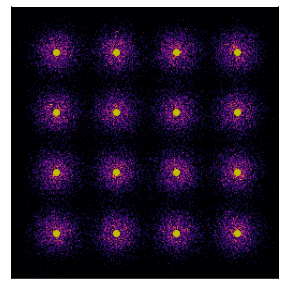

In [ ]:
y_plot,x_train,test,trsh,trsh, x_org = generateSet(15,0)
heatmap, xedges, yedges = np.histogram2d(y_plot[:,0], y_plot[:,1], bins=250)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(5,5))
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap='inferno')
tx = komm.QAModulation(16) 
const = tx.constellation
const = const/np.sqrt(np.mean(np.abs(const)**2))
plt.plot(np.real(const),np.imag(const),'yo')
plt.xticks([])
plt.yticks([])
print('Example constellation:')

Here we define the neural network. We use three hidden layers with 128 units. Note that the size of the NN is choosen to make sure that we do not have a too small network for the phase noise channel with some margin. However, for both channels a smaller NN can be used for most cases. The output is chosen to be M = 16 softmax nodes which is needed for the MI estimates.

In [ ]:
def createModel(M):
  model = Sequential()
  model.add(Dense(128, activation='relu',     kernel_initializer='he_normal'))
  model.add(Dense(128, activation='relu',     kernel_initializer='he_normal'))
  model.add(Dense(128, activation='relu',     kernel_initializer='he_normal'))
  model.add(Dense(M,  activation='softmax',  kernel_initializer='he_normal'))
  optimizer = keras.optimizers.Adam(learning_rate=0.0005)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc']) 

  return model

Below is the main loop for estimating MI using neural networks using the AWGN channel. This is done in two stages:

*   Train the neural network on data for the specific SNR 
*   Apply the neural network on the test data and use the outputs to calculate the MI

Note that the optimization function of the neural network is not tasked with finding the mutual information (i.e. it is not trained using for instance the known AWGN channel MI as target) but rather using the sofmax outputs which are trained on recovering the transmitted constellation points to calculate the MI.






In [ ]:
SNRdBVect = np.linspace(0,25,25)

MI = np.zeros(len(SNRdBVect))
MI_gauss =  np.zeros(len(SNRdBVect))
for k in range(len(SNRdBVect)):
  y_train, x_train, y_test, x_test, C_foo, x_org = generateSet(SNRdBVect[k],0)
  model = createModel(16)
  
  history = model.fit(y_train, x_train, epochs=5, batch_size=64, validation_data=(y_test,x_test))

  #Apply the learned model on the test data:
  y_hat = model.predict(y_test) #Apply the model to the test data
  N = np.argmax(x_test,axis=1) #Get the symbols symbols

  #Get the probability per symbol:
  unique, counts = np.unique(N, return_counts=True)
  p = counts/np.sum(counts)

  MI[k] = np.mean( np.log2( np.sum( y_hat*x_test, axis=-1) / (np.matmul(x_test,p))) )
  print('MI neural network:')
  print(MI)

  MI_gauss[k] = calcMIwrapper(x_org, x_train, y_train)
  print('MIGauss:')
  print(MI_gauss)


#Adjust the output size for better visibilty:
display.Javascript("google.colab.output.setIframeHeight('300px');")
  



0.0
Epoch 1/5
782/782 [==============================] - 2s 3ms/step - loss: 2.1508 - acc: 0.2346 - val_loss: 2.1331 - val_acc: 0.2419
Epoch 2/5
782/782 [==============================] - 2s 3ms/step - loss: 2.1095 - acc: 0.2467 - val_loss: 2.1082 - val_acc: 0.2512
Epoch 3/5
782/782 [==============================] - 2s 3ms/step - loss: 2.1038 - acc: 0.2485 - val_loss: 2.1106 - val_acc: 0.2514
Epoch 4/5
782/782 [==============================] - 2s 2ms/step - loss: 2.0993 - acc: 0.2518 - val_loss: 2.1022 - val_acc: 0.2536
Epoch 5/5
782/782 [==============================] - 2s 3ms/step - loss: 2.0973 - acc: 0.2543 - val_loss: 2.1052 - val_acc: 0.2522
MI neural network:
[0.96259801 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
MIGauss:
[0.9906891 0.        0.        0.        0.        0.        0.


<IPython.core.display.Javascript object>

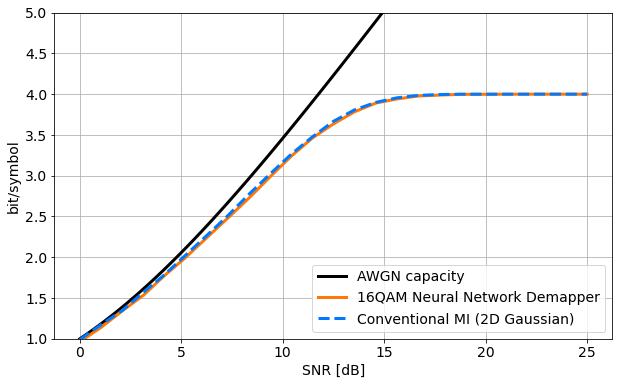

In [ ]:
# Plot results:
SNRdBsh = np.linspace(0,20,100)
SNR_sh = 10**(SNRdBsh/10)
C = np.log2(1 + SNR_sh)
pColor  = np.array([255,120,5])/255
pColor2 = np.array([0,120,255])/255

plt.rcParams.update({'font.size': 14}) #set fontsize
plt.figure(figsize=(10,6))
plt.plot(SNRdBsh,C,'k', linewidth=3)
plt.plot(SNRdBVect,MI,color=pColor, linewidth=3)
plt.plot(SNRdBVect,MI_gauss,color=pColor2,linestyle='--', linewidth=3)

plt.xlabel('SNR [dB]')
plt.ylabel('bit/symbol')
plt.legend(['AWGN capacity', '16QAM Neural Network Demapper', 'Conventional MI (2D Gaussian)'])
plt.ylim([1,5])
plt.grid(True)





---


Next lets look at our toy channel with power dependent phase noise:

15
Example constellation:


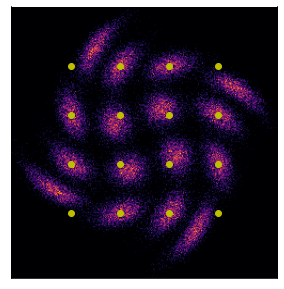

In [ ]:
y_plot,x_train,test,trsh,trsh, x_org = generateSet(15,0.35)
heatmap, xedges, yedges = np.histogram2d(y_plot[:,0], y_plot[:,1], bins=250)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
tx = komm.QAModulation(16) #create 16QAM transmitter
const = tx.constellation
const = const/np.sqrt(np.mean(np.abs(const)**2))

plt.figure(figsize=(5,5))
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap='inferno')
plt.plot(np.real(const),np.imag(const),'yo')
plt.xticks([])
plt.yticks([])
print('Example constellation:')

In [ ]:
SNRdBVect = np.linspace(0,25,25)

MI_pn = np.zeros(len(SNRdBVect))
MI_pn_gauss =  np.zeros(len(SNRdBVect))
for k in range(len(SNRdBVect)):
  y_train, x_train, y_test, x_test, C_foo, x_org = generateSet(SNRdBVect[k],0.35)
  model = createModel(16)
  
  history = model.fit(y_train, x_train, epochs=5, batch_size=64, validation_data=(y_test,x_test))

  #Apply the learned model on the test data:
  y_hat = model.predict(y_test)
  N = np.argmax(x_test,axis=1) #Get symbols

  #Get the probability per symbol:
  unique, counts = np.unique(N, return_counts=True)
  p = counts/np.sum(counts)

  MI_pn[k] = np.mean( np.log2( np.sum( y_hat*x_test, axis=-1) / (np.matmul(x_test,p))) )
  print('MI neural network:')
  print(MI_pn)

  MI_pn_gauss[k] = calcMIwrapper(x_org, x_train, y_train)
  print('MIGauss:')
  print(MI_pn_gauss)

#Adjust the output size for better visibilty:
display.Javascript("google.colab.output.setIframeHeight('300px');")


0.0
Epoch 1/5
782/782 [==============================] - 2s 3ms/step - loss: 2.4268 - acc: 0.1704 - val_loss: 2.3482 - val_acc: 0.2072
Epoch 2/5
782/782 [==============================] - 2s 2ms/step - loss: 2.2661 - acc: 0.2154 - val_loss: 2.1934 - val_acc: 0.2394
Epoch 3/5
782/782 [==============================] - 2s 2ms/step - loss: 2.1751 - acc: 0.2340 - val_loss: 2.1529 - val_acc: 0.2430
Epoch 4/5
782/782 [==============================] - 2s 3ms/step - loss: 2.1450 - acc: 0.2423 - val_loss: 2.1295 - val_acc: 0.2460
Epoch 5/5
782/782 [==============================] - 2s 3ms/step - loss: 2.1316 - acc: 0.2457 - val_loss: 2.1232 - val_acc: 0.2487
MI neural network:
[0.93650788 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
MIGauss:
[0.41191589 0.         0.         0.         0.         0.
 0.  

<IPython.core.display.Javascript object>



---


Below we plot the resuls for this channel. As seen, on this simple toy example the neural network can find a distribution that matches the PN-channel with AWGN and actually recover the information such as the MI is very close to that of the AWGN channel (this is since the relation is deterministic and simple to model). Note that for other channels the same might not apply.

This example is choosen to showcase that the neural network can be used to estimate the maximum mutual information of the specific system in a black box way without any prior knowledge or assumptions (beyond memoryless in this case) on the channel.

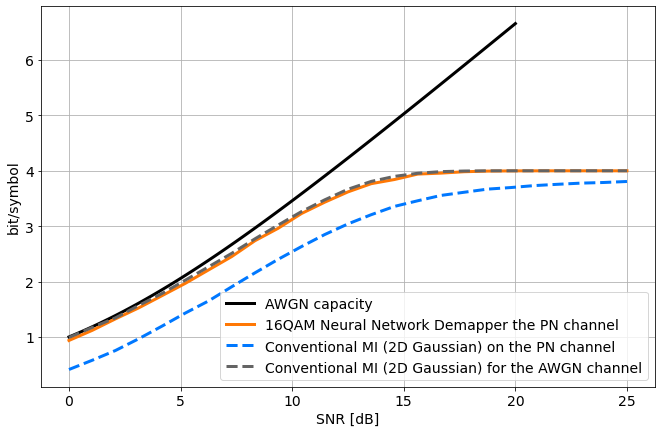

In [ ]:
# Plot results:
SNRdBsh = np.linspace(0,20,100)
SNR_sh = 10**(SNRdBsh/10)
C = np.log2(1 + SNR_sh)
pColor = np.array([255,120,5])/255
pColor2 = np.array([0,120,255])/255
pColor3 = np.array([100,100,100])/255

plt.figure(figsize=(11,7))
plt.plot(SNRdBsh,C,'k', linewidth=3)
plt.plot(SNRdBVect,MI_pn,color=pColor, linewidth=3)
plt.plot(SNRdBVect,MI_pn_gauss,color=pColor2,linestyle='--', linewidth=3)
plt.plot(SNRdBVect,MI_gauss,color=pColor3,linestyle='--', linewidth=3)

plt.xlabel('SNR [dB]')
plt.ylabel('bit/symbol')
plt.legend(['AWGN capacity', '16QAM Neural Network Demapper the PN channel', 'Conventional MI (2D Gaussian) on the PN channel', 'Conventional MI (2D Gaussian) for the AWGN channel'])
plt.grid(True)
